In [5]:
import pandahouse as ph
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

In [6]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-26' and '2022-10-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group', as_index=False).agg({'user_id': 'nunique'})

,exp_group,user_id
0,2,8480
1,3,8569


In [7]:
#Размерности групп примерно одинаковые

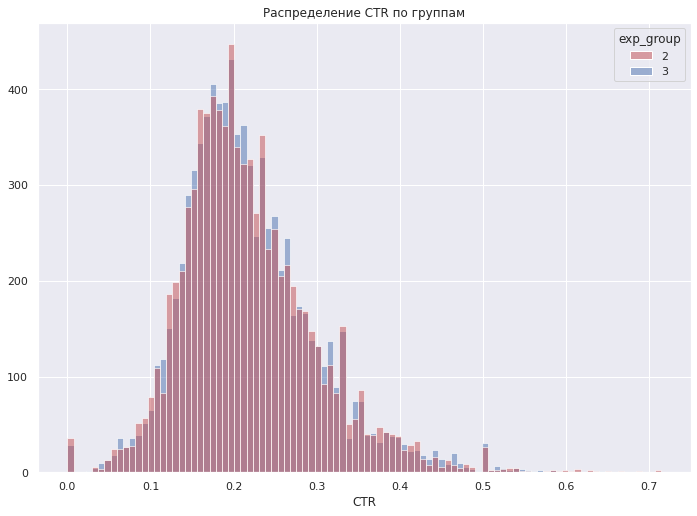

In [9]:
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.xlabel('CTR')
plt.ylabel('')
plt.title('Распределение CTR по группам')
plt.show()

In [10]:
#t-тест
print(stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False))

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)


In [ ]:
#Так как p-значение больше уровня значимости, оставляем нулевую гипотезу о равенстве средних.

In [11]:
#тест Манна-Уитни
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr))

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)


In [ ]:
#Отличие так же не прокрасилось.

In [12]:
#Симуляция 10000 АА-тестов
p_values = []
for _ in range(10000):
    ttest_p_value = stats.ttest_ind(df[df.exp_group == 2].sample(500, replace = False).ctr,
                      df[df.exp_group == 3].sample(500, replace = False).ctr,
                      equal_var=False)[1]
    p_values.append(ttest_p_value)

Text(0.5, 0, 'p-value')

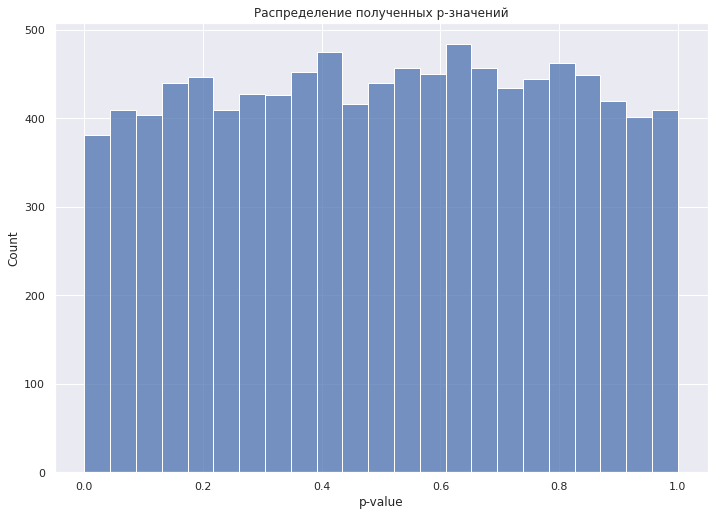

In [13]:
#гистограмма распределения получившихся p-value
sns.histplot(data = p_values, palette = ['b'])
plt.title('Распределение полученных p-значений')
plt.xlabel('p-value')

In [14]:
#процент p-values, оказавшихся меньше либо равен 0.05
p_values = pd.Series(p_values)
print('Процент p-values<=0.05: ' + str(len(p_values[p_values <= 0.05]) * 100 / len(p_values)) + '%')

Процент p-values<=0.05: 4.43%


Вывод: 
Система сплитования работает корректно. Мы получили практически равномерное распределение p-value, что говорит нам о том, что нулевые гипотезы верны. То есть группы 2 и 3 статистически не отличаются друг от друга.